<a href="https://www.kaggle.com/code/shuvookd/mocowithkdd?scriptVersionId=254834402" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent_corrected', header=None)
columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent",
    "hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
    "is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"
]
df.columns = columns

In [3]:
for col in ['protocol_type', 'service', 'flag']:
    df[col] = LabelEncoder().fit_transform(df[col])

df['label'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)

X = df.drop('label', axis=1)
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42)

--- Baseline Random Forest ---
Accuracy: 0.9998
F1 Score: 0.9999
Precision: 0.9999
Recall: 0.9998

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     29184
           1       1.00      1.00      1.00    119023

    accuracy                           1.00    148207
   macro avg       1.00      1.00      1.00    148207
weighted avg       1.00      1.00      1.00    148207



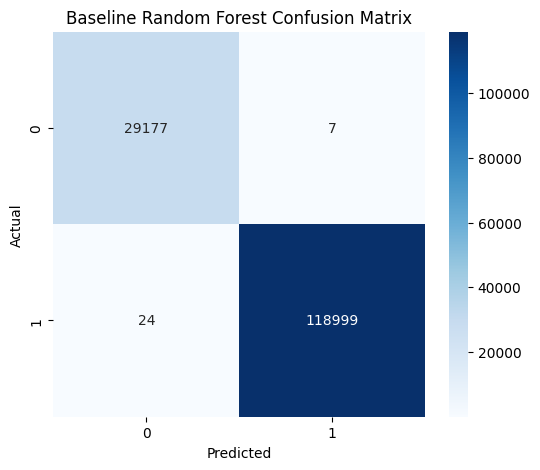

In [5]:
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
rf_baseline.fit(X_train, y_train)
y_pred_baseline = rf_baseline.predict(X_test)

def evaluate_model(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return {"Model": model_name, "Accuracy": acc, "F1": f1, "Precision": prec, "Recall": rec}

baseline_metrics = evaluate_model(y_test, y_pred_baseline, "Baseline Random Forest")

In [6]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 7: Define MLP Encoder for MoCo
class MLPEncoder(nn.Module):
    def __init__(self, input_dim=41, projection_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.projector = nn.Linear(128, projection_dim)

    def forward(self, x):
        feat = self.encoder(x)
        proj = self.projector(feat)
        return feat, proj

In [7]:
def augment(x):
    noise = torch.randn_like(x) * 0.1
    return x + noise

In [8]:
class MoCo:
    def __init__(self, input_dim=41, projection_dim=128, K=4096, m=0.999, device='cuda'):
        self.K = K
        self.m = m
        self.device = device

        self.query_encoder = MLPEncoder(input_dim, projection_dim).to(self.device)
        self.key_encoder = MLPEncoder(input_dim, projection_dim).to(self.device)
        self.key_encoder.load_state_dict(self.query_encoder.state_dict())
        self.key_encoder.eval()

        self.queue = torch.randn(projection_dim, K).to(self.device)
        self.queue = F.normalize(self.queue, dim=0)
        self.queue_ptr = 0

        self.optimizer = optim.Adam(self.query_encoder.parameters(), lr=1e-3)

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.query_encoder.parameters(), self.key_encoder.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]
        ptr = self.queue_ptr

        if ptr + batch_size <= self.K:
            self.queue[:, ptr:ptr + batch_size] = keys.T
        else:
            overflow = (ptr + batch_size) - self.K
            self.queue[:, ptr:self.K] = keys[:batch_size - overflow].T
            self.queue[:, 0:overflow] = keys[batch_size - overflow:].T

        self.queue_ptr = (ptr + batch_size) % self.K

    def train_one_epoch(self, dataloader, augment, temperature=0.07):
        self.query_encoder.train()
        total_loss = 0
        for batch in dataloader:
            x = batch[0].to(self.device)

            q_input = augment(x)
            k_input = augment(x)

            _, q = self.query_encoder(q_input)
            with torch.no_grad():
                _, k = self.key_encoder(k_input)

            q = F.normalize(q, dim=1)
            k = F.normalize(k, dim=1)

            l_pos = torch.bmm(q.view(q.size(0), 1, -1), k.view(k.size(0), -1, 1)).squeeze(-1).squeeze(-1)
            l_neg = torch.mm(q, self.queue.clone().detach())

            logits = torch.cat([l_pos.unsqueeze(1), l_neg], dim=1)
            labels = torch.zeros(logits.size(0), dtype=torch.long).to(self.device)

            logits /= temperature

            loss = F.cross_entropy(logits, labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self._momentum_update_key_encoder()
            self._dequeue_and_enqueue(k)

            total_loss += loss.item()

        return total_loss / len(dataloader)

    def extract_features(self, X_tensor, batch_size=128):
        self.query_encoder.eval()
        features = []
        with torch.no_grad():
            for i in range(0, len(X_tensor), batch_size):
                batch = X_tensor[i:i+batch_size].to(self.device)
                feat, _ = self.query_encoder(batch)
                features.append(feat.cpu())
        return torch.cat(features).numpy()

In [9]:
moco = MoCo(input_dim=41, projection_dim=128, K=4096, m=0.999, device=device)

In [10]:
num_epochs = 100
for epoch in range(num_epochs):
    loss = moco.train_one_epoch(train_loader, augment)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")

Epoch 1/100, Loss: 5.7961
Epoch 2/100, Loss: 5.7140
Epoch 3/100, Loss: 5.6822
Epoch 4/100, Loss: 5.6586
Epoch 5/100, Loss: 5.6552
Epoch 6/100, Loss: 5.6391
Epoch 7/100, Loss: 5.6387
Epoch 8/100, Loss: 5.6372
Epoch 9/100, Loss: 5.6304
Epoch 10/100, Loss: 5.6203
Epoch 11/100, Loss: 5.6287
Epoch 12/100, Loss: 5.6173
Epoch 13/100, Loss: 5.6258
Epoch 14/100, Loss: 5.6180
Epoch 15/100, Loss: 5.6253
Epoch 16/100, Loss: 5.6163
Epoch 17/100, Loss: 5.6188
Epoch 18/100, Loss: 5.6132
Epoch 19/100, Loss: 5.6035
Epoch 20/100, Loss: 5.6089
Epoch 21/100, Loss: 5.6038
Epoch 22/100, Loss: 5.5996
Epoch 23/100, Loss: 5.5936
Epoch 24/100, Loss: 5.5987
Epoch 25/100, Loss: 5.5895
Epoch 26/100, Loss: 5.5868
Epoch 27/100, Loss: 5.5850
Epoch 28/100, Loss: 5.5855
Epoch 29/100, Loss: 5.5670
Epoch 30/100, Loss: 5.5774
Epoch 31/100, Loss: 5.5797
Epoch 32/100, Loss: 5.5660
Epoch 33/100, Loss: 5.5636
Epoch 34/100, Loss: 5.5647
Epoch 35/100, Loss: 5.5631
Epoch 36/100, Loss: 5.5593
Epoch 37/100, Loss: 5.5622
Epoch 38/1

In [11]:
train_features = moco.extract_features(X_train_tensor)
test_features = moco.extract_features(X_test_tensor)

In [12]:
rf_moco = RandomForestClassifier(n_estimators=100, random_state=42)
rf_moco.fit(train_features, y_train)

y_pred_moco = rf_moco.predict(test_features)

--- MoCo + Random Forest ---
Accuracy: 0.9994
F1 Score: 0.9997
Precision: 0.9999
Recall: 0.9994

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     29184
           1       1.00      1.00      1.00    119023

    accuracy                           1.00    148207
   macro avg       1.00      1.00      1.00    148207
weighted avg       1.00      1.00      1.00    148207



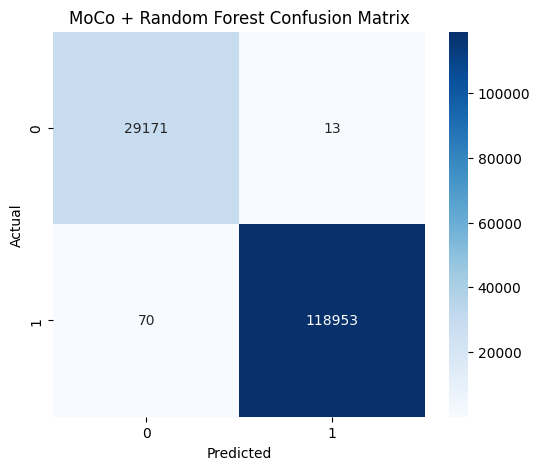

In [13]:
moco_metrics = evaluate_model(y_test, y_pred_moco, "MoCo + Random Forest")

In [14]:
results_df = pd.DataFrame([baseline_metrics, moco_metrics])
results_df.to_csv("kdd_moco_rf_results.csv", index=False)
print("Saved results to kdd_moco_rf_results.csv")

Saved results to kdd_moco_rf_results.csv


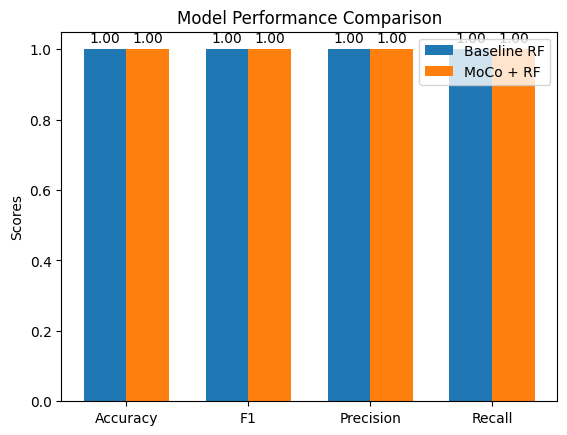

In [15]:
metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, results_df.loc[0, metrics], width, label='Baseline RF')
rects2 = ax.bar(x + width/2, results_df.loc[1, metrics], width, label='MoCo + RF')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 1.05)
plt.show()

/tmp/ipykernel_19/3836355103.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, results_df.loc[0, metrics][i] + 0.02, f"{results_df.loc[0, metrics][i]:.2f}", ha='center')
/tmp/ipykernel_19/3836355103.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, results_df.loc[0, metrics][i] + 0.02, f"{results_df.loc[0, metrics][i]:.2f}", ha='center')
/tmp/ipykernel_19/3836355103.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

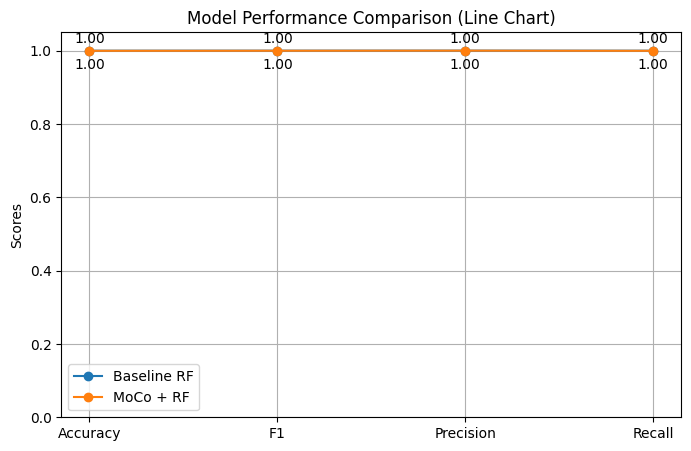

In [16]:
metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
x = np.arange(len(metrics))

plt.figure(figsize=(8,5))

# Plot lines for each model
plt.plot(x, results_df.loc[0, metrics], marker='o', label='Baseline RF')
plt.plot(x, results_df.loc[1, metrics], marker='o', label='MoCo + RF')

# Add metric names as x-ticks
plt.xticks(x, metrics)

# Labels and title
plt.ylabel('Scores')
plt.title('Model Performance Comparison (Line Chart)')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()

# Annotate points with exact values
for i in x:
    plt.text(i, results_df.loc[0, metrics][i] + 0.02, f"{results_df.loc[0, metrics][i]:.2f}", ha='center')
    plt.text(i, results_df.loc[1, metrics][i] - 0.05, f"{results_df.loc[1, metrics][i]:.2f}", ha='center')

plt.show()